In [1]:
# importing libaries

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

In [2]:
class LEMCell(nn.Module):
    def __init__(self, ninp, nhid, dt):
        super(LEMCell, self).__init__()
        self.ninp = ninp
        self.nhid = nhid
        self.dt = dt
        self.inp2hid = nn.Linear(ninp, 4 * nhid)
        self.hid2hid = nn.Linear(nhid, 3 * nhid)
        self.transform_z = nn.Linear(nhid, nhid)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.nhid)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, y, z):
        transformed_inp = self.inp2hid(x)
        transformed_hid = self.hid2hid(y)
        i_dt1, i_dt2, i_z, i_y = transformed_inp.chunk(4, 1)
        h_dt1, h_dt2, h_y = transformed_hid.chunk(3, 1)

        ms_dt_bar = self.dt * torch.sigmoid(i_dt1 + h_dt1)
        ms_dt = self.dt * torch.sigmoid(i_dt2 + h_dt2)

        z = (1. - ms_dt) * z + ms_dt * torch.tanh(i_y + h_y)
        y = (1. - ms_dt_bar) * y + ms_dt_bar * torch.tanh(self.transform_z(z) + i_z)

        return y, z

# Define the LEM model
class LEM(nn.Module):
    def __init__(self, ninp, nhid, nout, dt=1.):
        super(LEM, self).__init__()
        self.nhid = nhid
        self.cell = LEMCell(ninp, nhid, dt)
        self.classifier = nn.Linear(nhid, nout)
        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'classifier' in name and 'weight' in name:
                nn.init.kaiming_normal_(param.data)

    def forward(self, input):
        y = input.data.new(input.size(1), self.nhid).zero_()
        z = input.data.new(input.size(1), self.nhid).zero_()
        for x in input:
            y, z = self.cell(x, y, z)
        out = self.classifier(y)
        return out

In [3]:
# Toy problem data
input_size = 256  # number of columns in a dataset
hidden_size = 32  # number of neurons
output_size = 256  
sequence_length = 160  # number of sequences/ number of rows
batch_size = 1
num_epochs = 30000

### importing PINN solution

In [4]:
# Load the .mat file
v_data = scipy.io.loadmat('v.mat')
h_data = scipy.io.loadmat('h.mat')
x_data = scipy.io.loadmat('x.mat')

In [5]:
x = x_data['X']
u = h_data['h']

In [6]:
# Set random seed for reproducibility
torch.manual_seed(40)

In [7]:
input_data = u[0:160,:]
target_data = u[1:161, :]

test_data = u[160, :]
#test_target = u[161:201, :]

print("test data shape", test_data.shape)
#print("test target shape", test_target.shape)

print("input data shape",input_data.shape)
print("Target data shape",target_data.shape)

test data shape (256,)
input data shape (160, 256)
Target data shape (160, 256)


In [8]:
# Convert data to tensors
input_tensor = torch.tensor(input_data).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data).view(batch_size, sequence_length, output_size).float()

print("input tensor shape",input_tensor.shape)
print("Target tensor shape",target_tensor.shape)

input tensor shape torch.Size([1, 160, 256])
Target tensor shape torch.Size([1, 160, 256])


In [9]:
# Convert test data to tensors
test_tensor = torch.tensor(test_data).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target).view(batch_size, 40, output_size).float()


In [10]:
# # Create LEM instance
# lem = LEM(input_size, hidden_size, output_size, dt=0.01)

# # Loss and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(lem.parameters(), lr=0.1)
# Create LEM instance :: niche h RNN vala 
lem = LEM(input_size, hidden_size, output_size, dt=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lem.parameters(), lr=0.01)



# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = lem(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch: {epoch + 1}/{num_epochs}, Loss: {loss.item():.6f}')




Epoch: 10/30000, Loss: 0.456984
Epoch: 20/30000, Loss: 0.271237
Epoch: 30/30000, Loss: 0.167751
Epoch: 40/30000, Loss: 0.103514
Epoch: 50/30000, Loss: 0.065797
Epoch: 60/30000, Loss: 0.046000
Epoch: 70/30000, Loss: 0.036677
Epoch: 80/30000, Loss: 0.032639
Epoch: 90/30000, Loss: 0.031064
Epoch: 100/30000, Loss: 0.030535
Epoch: 110/30000, Loss: 0.030387
Epoch: 120/30000, Loss: 0.030356
Epoch: 130/30000, Loss: 0.030350


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 160, 256])) that is different to the input size (torch.Size([160, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 140/30000, Loss: 0.030349
Epoch: 150/30000, Loss: 0.030349
Epoch: 160/30000, Loss: 0.030348
Epoch: 170/30000, Loss: 0.030348
Epoch: 180/30000, Loss: 0.030348
Epoch: 190/30000, Loss: 0.030348
Epoch: 200/30000, Loss: 0.030348
Epoch: 210/30000, Loss: 0.030348
Epoch: 220/30000, Loss: 0.030348
Epoch: 230/30000, Loss: 0.030348
Epoch: 240/30000, Loss: 0.030348
Epoch: 250/30000, Loss: 0.030348
Epoch: 260/30000, Loss: 0.030348
Epoch: 270/30000, Loss: 0.030348
Epoch: 280/30000, Loss: 0.030348
Epoch: 290/30000, Loss: 0.030348
Epoch: 300/30000, Loss: 0.030348
Epoch: 310/30000, Loss: 0.030348
Epoch: 320/30000, Loss: 0.030348
Epoch: 330/30000, Loss: 0.030348
Epoch: 340/30000, Loss: 0.030348
Epoch: 350/30000, Loss: 0.030348
Epoch: 360/30000, Loss: 0.030348
Epoch: 370/30000, Loss: 0.030347
Epoch: 380/30000, Loss: 0.030347
Epoch: 390/30000, Loss: 0.030347
Epoch: 400/30000, Loss: 0.030347
Epoch: 410/30000, Loss: 0.030346
Epoch: 420/30000, Loss: 0.030343
Epoch: 430/30000, Loss: 0.030054
Epoch: 440

Epoch: 2610/30000, Loss: 0.000752
Epoch: 2620/30000, Loss: 0.000748
Epoch: 2630/30000, Loss: 0.000748
Epoch: 2640/30000, Loss: 0.001051
Epoch: 2650/30000, Loss: 0.000745
Epoch: 2660/30000, Loss: 0.000758
Epoch: 2670/30000, Loss: 0.000744
Epoch: 2680/30000, Loss: 0.000729
Epoch: 2690/30000, Loss: 0.000728
Epoch: 2700/30000, Loss: 0.000724
Epoch: 2710/30000, Loss: 0.000720
Epoch: 2720/30000, Loss: 0.000717
Epoch: 2730/30000, Loss: 0.000714
Epoch: 2740/30000, Loss: 0.000711
Epoch: 2750/30000, Loss: 0.000708
Epoch: 2760/30000, Loss: 0.000707
Epoch: 2770/30000, Loss: 0.000871
Epoch: 2780/30000, Loss: 0.000807
Epoch: 2790/30000, Loss: 0.000709
Epoch: 2800/30000, Loss: 0.000712
Epoch: 2810/30000, Loss: 0.000693
Epoch: 2820/30000, Loss: 0.000693
Epoch: 2830/30000, Loss: 0.000689
Epoch: 2840/30000, Loss: 0.000686
Epoch: 2850/30000, Loss: 0.000683
Epoch: 2860/30000, Loss: 0.000681
Epoch: 2870/30000, Loss: 0.000678
Epoch: 2880/30000, Loss: 0.000676
Epoch: 2890/30000, Loss: 0.000684
Epoch: 2900/30

Epoch: 5090/30000, Loss: 0.000222
Epoch: 5100/30000, Loss: 0.000187
Epoch: 5110/30000, Loss: 0.000185
Epoch: 5120/30000, Loss: 0.000183
Epoch: 5130/30000, Loss: 0.000189
Epoch: 5140/30000, Loss: 0.000184
Epoch: 5150/30000, Loss: 0.000181
Epoch: 5160/30000, Loss: 0.000179
Epoch: 5170/30000, Loss: 0.000177
Epoch: 5180/30000, Loss: 0.000176
Epoch: 5190/30000, Loss: 0.000181
Epoch: 5200/30000, Loss: 0.000465
Epoch: 5210/30000, Loss: 0.000314
Epoch: 5220/30000, Loss: 0.000183
Epoch: 5230/30000, Loss: 0.000176
Epoch: 5240/30000, Loss: 0.000178
Epoch: 5250/30000, Loss: 0.000173
Epoch: 5260/30000, Loss: 0.000170
Epoch: 5270/30000, Loss: 0.000168
Epoch: 5280/30000, Loss: 0.000167
Epoch: 5290/30000, Loss: 0.000166
Epoch: 5300/30000, Loss: 0.000165
Epoch: 5310/30000, Loss: 0.000165
Epoch: 5320/30000, Loss: 0.000165
Epoch: 5330/30000, Loss: 0.000288
Epoch: 5340/30000, Loss: 0.000225
Epoch: 5350/30000, Loss: 0.000234
Epoch: 5360/30000, Loss: 0.000162
Epoch: 5370/30000, Loss: 0.000169
Epoch: 5380/30

Epoch: 7580/30000, Loss: 0.000113
Epoch: 7590/30000, Loss: 0.000113
Epoch: 7600/30000, Loss: 0.000113
Epoch: 7610/30000, Loss: 0.000112
Epoch: 7620/30000, Loss: 0.000113
Epoch: 7630/30000, Loss: 0.000112
Epoch: 7640/30000, Loss: 0.000112
Epoch: 7650/30000, Loss: 0.000112
Epoch: 7660/30000, Loss: 0.000112
Epoch: 7670/30000, Loss: 0.000112
Epoch: 7680/30000, Loss: 0.000112
Epoch: 7690/30000, Loss: 0.000143
Epoch: 7700/30000, Loss: 0.000409
Epoch: 7710/30000, Loss: 0.000202
Epoch: 7720/30000, Loss: 0.000132
Epoch: 7730/30000, Loss: 0.000127
Epoch: 7740/30000, Loss: 0.000114
Epoch: 7750/30000, Loss: 0.000113
Epoch: 7760/30000, Loss: 0.000112
Epoch: 7770/30000, Loss: 0.000111
Epoch: 7780/30000, Loss: 0.000111
Epoch: 7790/30000, Loss: 0.000111
Epoch: 7800/30000, Loss: 0.000111
Epoch: 7810/30000, Loss: 0.000111
Epoch: 7820/30000, Loss: 0.000111
Epoch: 7830/30000, Loss: 0.000111
Epoch: 7840/30000, Loss: 0.000111
Epoch: 7850/30000, Loss: 0.000111
Epoch: 7860/30000, Loss: 0.000111
Epoch: 7870/30

Epoch: 10000/30000, Loss: 0.000106
Epoch: 10010/30000, Loss: 0.000104
Epoch: 10020/30000, Loss: 0.000102
Epoch: 10030/30000, Loss: 0.000099
Epoch: 10040/30000, Loss: 0.000099
Epoch: 10050/30000, Loss: 0.000099
Epoch: 10060/30000, Loss: 0.000099
Epoch: 10070/30000, Loss: 0.000099
Epoch: 10080/30000, Loss: 0.000099
Epoch: 10090/30000, Loss: 0.000099
Epoch: 10100/30000, Loss: 0.000099
Epoch: 10110/30000, Loss: 0.000099
Epoch: 10120/30000, Loss: 0.000099
Epoch: 10130/30000, Loss: 0.000103
Epoch: 10140/30000, Loss: 0.000413
Epoch: 10150/30000, Loss: 0.000299
Epoch: 10160/30000, Loss: 0.000108
Epoch: 10170/30000, Loss: 0.000118
Epoch: 10180/30000, Loss: 0.000106
Epoch: 10190/30000, Loss: 0.000098
Epoch: 10200/30000, Loss: 0.000099
Epoch: 10210/30000, Loss: 0.000099
Epoch: 10220/30000, Loss: 0.000098
Epoch: 10230/30000, Loss: 0.000098
Epoch: 10240/30000, Loss: 0.000098
Epoch: 10250/30000, Loss: 0.000098
Epoch: 10260/30000, Loss: 0.000098
Epoch: 10270/30000, Loss: 0.000098
Epoch: 10280/30000, 

Epoch: 12360/30000, Loss: 0.000100
Epoch: 12370/30000, Loss: 0.000097
Epoch: 12380/30000, Loss: 0.000092
Epoch: 12390/30000, Loss: 0.000091
Epoch: 12400/30000, Loss: 0.000090
Epoch: 12410/30000, Loss: 0.000090
Epoch: 12420/30000, Loss: 0.000090
Epoch: 12430/30000, Loss: 0.000090
Epoch: 12440/30000, Loss: 0.000090
Epoch: 12450/30000, Loss: 0.000089
Epoch: 12460/30000, Loss: 0.000092
Epoch: 12470/30000, Loss: 0.000350
Epoch: 12480/30000, Loss: 0.000307
Epoch: 12490/30000, Loss: 0.000098
Epoch: 12500/30000, Loss: 0.000116
Epoch: 12510/30000, Loss: 0.000096
Epoch: 12520/30000, Loss: 0.000090
Epoch: 12530/30000, Loss: 0.000091
Epoch: 12540/30000, Loss: 0.000090
Epoch: 12550/30000, Loss: 0.000089
Epoch: 12560/30000, Loss: 0.000089
Epoch: 12570/30000, Loss: 0.000089
Epoch: 12580/30000, Loss: 0.000089
Epoch: 12590/30000, Loss: 0.000089
Epoch: 12600/30000, Loss: 0.000089
Epoch: 12610/30000, Loss: 0.000089
Epoch: 12620/30000, Loss: 0.000089
Epoch: 12630/30000, Loss: 0.000117
Epoch: 12640/30000, 

Epoch: 14720/30000, Loss: 0.000138
Epoch: 14730/30000, Loss: 0.000123
Epoch: 14740/30000, Loss: 0.000071
Epoch: 14750/30000, Loss: 0.000070
Epoch: 14760/30000, Loss: 0.000072
Epoch: 14770/30000, Loss: 0.000070
Epoch: 14780/30000, Loss: 0.000066
Epoch: 14790/30000, Loss: 0.000067
Epoch: 14800/30000, Loss: 0.000068
Epoch: 14810/30000, Loss: 0.000081
Epoch: 14820/30000, Loss: 0.000259
Epoch: 14830/30000, Loss: 0.000107
Epoch: 14840/30000, Loss: 0.000074
Epoch: 14850/30000, Loss: 0.000067
Epoch: 14860/30000, Loss: 0.000073
Epoch: 14870/30000, Loss: 0.000066
Epoch: 14880/30000, Loss: 0.000069
Epoch: 14890/30000, Loss: 0.000079
Epoch: 14900/30000, Loss: 0.000179
Epoch: 14910/30000, Loss: 0.000067
Epoch: 14920/30000, Loss: 0.000089
Epoch: 14930/30000, Loss: 0.000076
Epoch: 14940/30000, Loss: 0.000072
Epoch: 14950/30000, Loss: 0.000066
Epoch: 14960/30000, Loss: 0.000065
Epoch: 14970/30000, Loss: 0.000066
Epoch: 14980/30000, Loss: 0.000123
Epoch: 14990/30000, Loss: 0.000175
Epoch: 15000/30000, 

Epoch: 17080/30000, Loss: 0.000062
Epoch: 17090/30000, Loss: 0.000062
Epoch: 17100/30000, Loss: 0.000062
Epoch: 17110/30000, Loss: 0.000062
Epoch: 17120/30000, Loss: 0.000062
Epoch: 17130/30000, Loss: 0.000062
Epoch: 17140/30000, Loss: 0.000062
Epoch: 17150/30000, Loss: 0.000064
Epoch: 17160/30000, Loss: 0.000063
Epoch: 17170/30000, Loss: 0.000063
Epoch: 17180/30000, Loss: 0.000062
Epoch: 17190/30000, Loss: 0.000062
Epoch: 17200/30000, Loss: 0.000062
Epoch: 17210/30000, Loss: 0.000062
Epoch: 17220/30000, Loss: 0.000062
Epoch: 17230/30000, Loss: 0.000062
Epoch: 17240/30000, Loss: 0.000062
Epoch: 17250/30000, Loss: 0.000062
Epoch: 17260/30000, Loss: 0.000062
Epoch: 17270/30000, Loss: 0.000062
Epoch: 17280/30000, Loss: 0.000062
Epoch: 17290/30000, Loss: 0.000062
Epoch: 17300/30000, Loss: 0.000061
Epoch: 17310/30000, Loss: 0.000061
Epoch: 17320/30000, Loss: 0.000061
Epoch: 17330/30000, Loss: 0.000061
Epoch: 17340/30000, Loss: 0.000063
Epoch: 17350/30000, Loss: 0.000374
Epoch: 17360/30000, 

Epoch: 19490/30000, Loss: 0.000060
Epoch: 19500/30000, Loss: 0.000060
Epoch: 19510/30000, Loss: 0.000065
Epoch: 19520/30000, Loss: 0.000078
Epoch: 19530/30000, Loss: 0.000116
Epoch: 19540/30000, Loss: 0.000084
Epoch: 19550/30000, Loss: 0.000064
Epoch: 19560/30000, Loss: 0.000099
Epoch: 19570/30000, Loss: 0.000109
Epoch: 19580/30000, Loss: 0.000062
Epoch: 19590/30000, Loss: 0.000086
Epoch: 19600/30000, Loss: 0.000095
Epoch: 19610/30000, Loss: 0.000067
Epoch: 19620/30000, Loss: 0.000081
Epoch: 19630/30000, Loss: 0.000176
Epoch: 19640/30000, Loss: 0.000064
Epoch: 19650/30000, Loss: 0.000073
Epoch: 19660/30000, Loss: 0.000063
Epoch: 19670/30000, Loss: 0.000070
Epoch: 19680/30000, Loss: 0.000079
Epoch: 19690/30000, Loss: 0.000117
Epoch: 19700/30000, Loss: 0.000088
Epoch: 19710/30000, Loss: 0.000065
Epoch: 19720/30000, Loss: 0.000093
Epoch: 19730/30000, Loss: 0.000100
Epoch: 19740/30000, Loss: 0.000059
Epoch: 19750/30000, Loss: 0.000067
Epoch: 19760/30000, Loss: 0.000133
Epoch: 19770/30000, 

Epoch: 21840/30000, Loss: 0.000056
Epoch: 21850/30000, Loss: 0.000060
Epoch: 21860/30000, Loss: 0.000073
Epoch: 21870/30000, Loss: 0.000126
Epoch: 21880/30000, Loss: 0.000068
Epoch: 21890/30000, Loss: 0.000074
Epoch: 21900/30000, Loss: 0.000079
Epoch: 21910/30000, Loss: 0.000061
Epoch: 21920/30000, Loss: 0.000061
Epoch: 21930/30000, Loss: 0.000136
Epoch: 21940/30000, Loss: 0.000089
Epoch: 21950/30000, Loss: 0.000081
Epoch: 21960/30000, Loss: 0.000073
Epoch: 21970/30000, Loss: 0.000054
Epoch: 21980/30000, Loss: 0.000059
Epoch: 21990/30000, Loss: 0.000057
Epoch: 22000/30000, Loss: 0.000068
Epoch: 22010/30000, Loss: 0.000199
Epoch: 22020/30000, Loss: 0.000060
Epoch: 22030/30000, Loss: 0.000054
Epoch: 22040/30000, Loss: 0.000065
Epoch: 22050/30000, Loss: 0.000057
Epoch: 22060/30000, Loss: 0.000057
Epoch: 22070/30000, Loss: 0.000056
Epoch: 22080/30000, Loss: 0.000074
Epoch: 22090/30000, Loss: 0.000259
Epoch: 22100/30000, Loss: 0.000109
Epoch: 22110/30000, Loss: 0.000070
Epoch: 22120/30000, 

Epoch: 24290/30000, Loss: 0.000030
Epoch: 24300/30000, Loss: 0.000022
Epoch: 24310/30000, Loss: 0.000023
Epoch: 24320/30000, Loss: 0.000036
Epoch: 24330/30000, Loss: 0.000100
Epoch: 24340/30000, Loss: 0.000020
Epoch: 24350/30000, Loss: 0.000073
Epoch: 24360/30000, Loss: 0.000026
Epoch: 24370/30000, Loss: 0.000043
Epoch: 24380/30000, Loss: 0.000084
Epoch: 24390/30000, Loss: 0.000030
Epoch: 24400/30000, Loss: 0.000072
Epoch: 24410/30000, Loss: 0.000019
Epoch: 24420/30000, Loss: 0.000048
Epoch: 24430/30000, Loss: 0.000078
Epoch: 24440/30000, Loss: 0.000038
Epoch: 24450/30000, Loss: 0.000062
Epoch: 24460/30000, Loss: 0.000018
Epoch: 24470/30000, Loss: 0.000051
Epoch: 24480/30000, Loss: 0.000076
Epoch: 24490/30000, Loss: 0.000043
Epoch: 24500/30000, Loss: 0.000053
Epoch: 24510/30000, Loss: 0.000018
Epoch: 24520/30000, Loss: 0.000051
Epoch: 24530/30000, Loss: 0.000079
Epoch: 24540/30000, Loss: 0.000042
Epoch: 24550/30000, Loss: 0.000051
Epoch: 24560/30000, Loss: 0.000018
Epoch: 24570/30000, 

Epoch: 26680/30000, Loss: 0.000038
Epoch: 26690/30000, Loss: 0.000020
Epoch: 26700/30000, Loss: 0.000010
Epoch: 26710/30000, Loss: 0.000012
Epoch: 26720/30000, Loss: 0.000012
Epoch: 26730/30000, Loss: 0.000010
Epoch: 26740/30000, Loss: 0.000009
Epoch: 26750/30000, Loss: 0.000009
Epoch: 26760/30000, Loss: 0.000010
Epoch: 26770/30000, Loss: 0.000080
Epoch: 26780/30000, Loss: 0.000039
Epoch: 26790/30000, Loss: 0.000139
Epoch: 26800/30000, Loss: 0.000012
Epoch: 26810/30000, Loss: 0.000027
Epoch: 26820/30000, Loss: 0.000010
Epoch: 26830/30000, Loss: 0.000011
Epoch: 26840/30000, Loss: 0.000010
Epoch: 26850/30000, Loss: 0.000010
Epoch: 26860/30000, Loss: 0.000009
Epoch: 26870/30000, Loss: 0.000009
Epoch: 26880/30000, Loss: 0.000009
Epoch: 26890/30000, Loss: 0.000009
Epoch: 26900/30000, Loss: 0.000009
Epoch: 26910/30000, Loss: 0.000009
Epoch: 26920/30000, Loss: 0.000009
Epoch: 26930/30000, Loss: 0.000022
Epoch: 26940/30000, Loss: 0.000523
Epoch: 26950/30000, Loss: 0.000069
Epoch: 26960/30000, 

Epoch: 29080/30000, Loss: 0.000010
Epoch: 29090/30000, Loss: 0.000008
Epoch: 29100/30000, Loss: 0.000008
Epoch: 29110/30000, Loss: 0.000008
Epoch: 29120/30000, Loss: 0.000008
Epoch: 29130/30000, Loss: 0.000008
Epoch: 29140/30000, Loss: 0.000008
Epoch: 29150/30000, Loss: 0.000009
Epoch: 29160/30000, Loss: 0.000068
Epoch: 29170/30000, Loss: 0.000112
Epoch: 29180/30000, Loss: 0.000040
Epoch: 29190/30000, Loss: 0.000045
Epoch: 29200/30000, Loss: 0.000013
Epoch: 29210/30000, Loss: 0.000008
Epoch: 29220/30000, Loss: 0.000008
Epoch: 29230/30000, Loss: 0.000008
Epoch: 29240/30000, Loss: 0.000008
Epoch: 29250/30000, Loss: 0.000008
Epoch: 29260/30000, Loss: 0.000008
Epoch: 29270/30000, Loss: 0.000009
Epoch: 29280/30000, Loss: 0.000009
Epoch: 29290/30000, Loss: 0.000062
Epoch: 29300/30000, Loss: 0.000132
Epoch: 29310/30000, Loss: 0.000011
Epoch: 29320/30000, Loss: 0.000026
Epoch: 29330/30000, Loss: 0.000019
Epoch: 29340/30000, Loss: 0.000012
Epoch: 29350/30000, Loss: 0.000009
Epoch: 29360/30000, 

### Exact solution

(1, 256)
(1, 201)
(201, 256)


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.8/dist-packages/matplotlib/contour.py:1180: ComplexWarning: Casting complex values to real discards the imaginary part
  self.levels = np.asarray(levels_arg).astype(np.float64)


<Figure size 432x288 with 0 Axes>

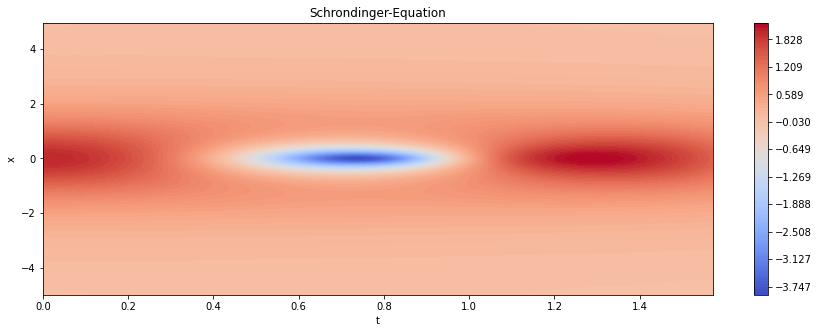

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split

# Load the .mat file
mat_data = scipy.io.loadmat('NLS.mat')

# Following is the code to plot the data u vs x and t. u is 256*100
# matrix. Use first 75 columns for training and 25 for testing :)

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['tt']
u1 = mat_data['uu']

# Use the loaded variables as needed
print(x.shape)
print(t.shape)
print(u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u1), np.max(u1), 100)

# Plot the contour
plt.figure()
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u1.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Schrondinger-Equation')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [12]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 40, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 40, 256])


In [13]:
with torch.no_grad():
    prediction = lem(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(39):
        prediction = lem(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction
        


### Errors

### L2 norm

In [14]:
test_tensor.shape

torch.Size([1, 1, 256])

In [15]:
# true solution
h_true = np.abs(u1)
h_true = h_true.T
print(h_true.shape)

(201, 256)


In [16]:
# exact
u_test_full = h_true[161:201, :]
print(u_test_full.shape)

(40, 256)


In [17]:
# with torch.no_grad():
#     prediction = lem(test_tensor)

# prediction.shape

In [18]:

k1 = (prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
prediction_tensor.shape

torch.Size([1, 40, 256])

In [19]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.0034094245940860693 %


### Max error

In [20]:
R_abs = torch.max(prediction_tensor-u_test_full)
print(R_abs)

tensor(0.0948, dtype=torch.float64)


### Explained variance score

In [21]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())


Explained Variance Score: 0.9944356146690461


### Mean absolute error

In [22]:
R_mean = torch.mean(torch.abs(prediction_tensor - u_test_full))
print(R_mean)

tensor(0.0281, dtype=torch.float64)


In [23]:
## t= 1.28, 1.5, 1.37

### snapshots

In [24]:
prediction_tensor = torch.squeeze(prediction_tensor)
h = np.abs(u)
h.shape

(201, 256)

(256, 1)
(256, 1)


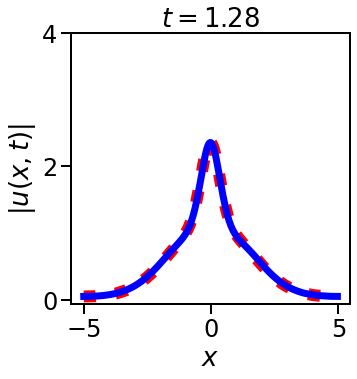

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)

final_time_output = prediction_tensor[-38, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[-38, :].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${|u(x, t)|}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.28}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_1.28_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


(256, 1)
(256, 1)


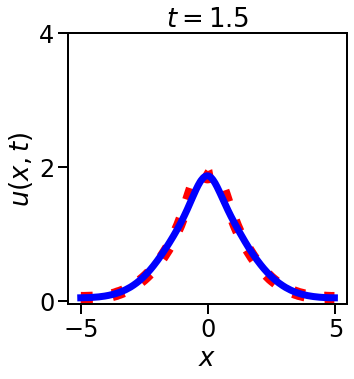

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed

# # Make sure the font is Times Roman
# plt.rcParams['font.family'] = 'Times New Roman'

# # Perform the prediction
# with torch.no_grad():
#     prediction = lem(test_tensor)


final_time_output = prediction_tensor[-3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = h[-3, :].reshape(-1, 1)
print(final_out.shape)
print(final_true.shape)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x.T, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x.T, final_true, color='blue', linestyle='solid', linewidth=7, label='True')

# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 1.5}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-5, 0, 5])
ax.set_yticks([0, 2, 4])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)


# Increase font size for x and y axis numbers
ax.tick_params(axis='both', which='major', labelsize=24)

# Set the legend
# ax.legend()

plt.savefig('LEM_1.5_20.pdf', dpi=500, bbox_inches="tight")

# Show the plot
plt.show()


### 80-20 contour plot

In [27]:
conc_u = torch.squeeze(input_tensor)

In [28]:
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

t1 = np.linspace(0, 1.5707 , 200)

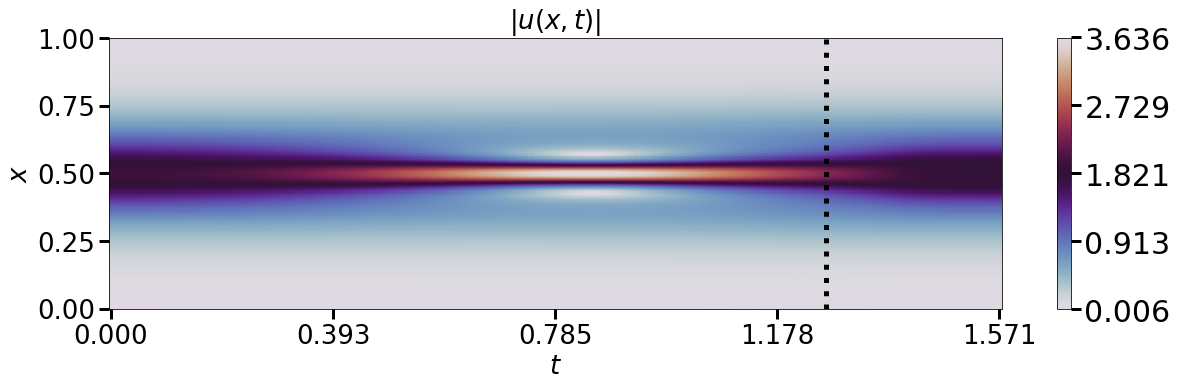

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$|u(x, t)|$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=1.26449, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_LEM_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### exact contour

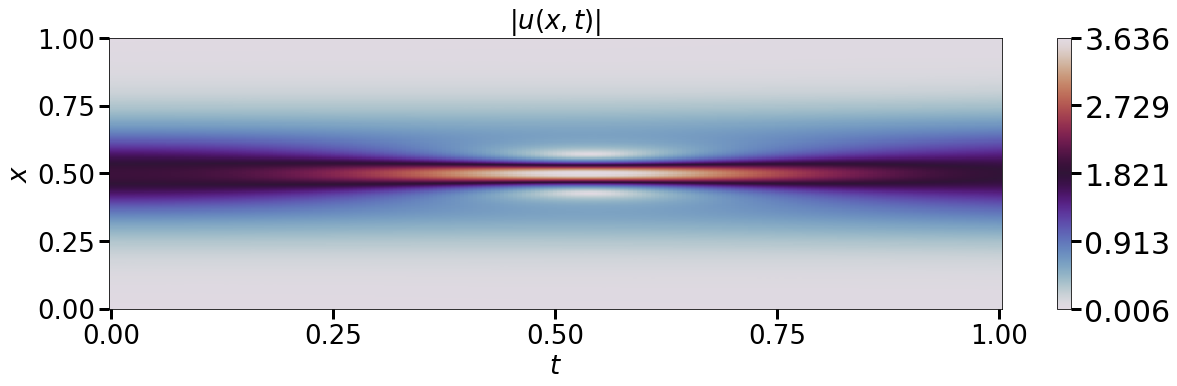

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = h

# Define custom color levels
x = np.linspace(0, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='twilight')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$|u(x, t)|$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

#plt.savefig('Contour_Exact.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_exact.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
